In [1]:
import pandas as pd
from transformers import pipeline
import tqdm
tqdm.tqdm.pandas()

In [2]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("T'estimo!")

[{'label': 'Positive', 'score': 0.6600587964057922}]

In [3]:
reader = pd.read_json("conversations_flat.json", lines=True, dtype={"id": str, "author_id": str, "conversation_id": str}, chunksize=1000)

dfs = []
for chunk in reader:
    df = chunk[["id", "text", "author_id", "conversation_id", "created_at"]]
    dfs.append(df)
    
tweets = pd.concat(dfs)
    
tweets["text"] = tweets["text"].str.replace(r"http\S+", "")
tweets.head()

/tmp/ipykernel_28726/2247558924.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets["text"] = tweets["text"].str.replace(r"http\S+", "")


,id,text,author_id,conversation_id,created_at
0,1314540427874308097,@RobinMillarMP @AlyAShields @BetsiCadwaladr @h...,709375301583835137,1314477726678614016,2020-10-09 12:17:15+00:00
1,1314533448405614592,@RobinMillarMP @BetsiCadwaladr @healthdpt @NIC...,470801601,1314477726678614016,2020-10-09 11:49:31+00:00
2,1314509086596239362,@RobinMillarMP @AlyAShields @BetsiCadwaladr @h...,816444807371517952,1314477726678614016,2020-10-09 10:12:43+00:00
3,1314493025700077568,@AlyAShields @BetsiCadwaladr @healthdpt @NICEC...,1194759472087998465,1314477726678614016,2020-10-09 09:08:54+00:00
4,1314477729371299840,@BetsiCadwaladr @CALL_247 @MindCymru @Research...,470801601,1314477726678614016,2020-10-09 08:08:07+00:00


In [4]:
def get_sentiment(x):
    return sentiment_task(x)[0]['label']

tweets["sentiment"] = tweets["text"].progress_map(get_sentiment)

100%|███████████████████████████████████████████████████████████████████████████| 52302/52302 [2:09:49<00:00,  6.71it/s]


In [5]:
tweets = tweets.set_index("id")
tweets["sentiment"].to_csv("tweet_sentiment.csv")

In [6]:
tweets["sentiment"].value_counts()

Negative    28683
Neutral     17236
Positive     6383
Name: sentiment, dtype: int64

In [7]:
# def split_label(x):
#     print(x)
#     if x <= "2020-01-01 00:00:00+00:00":
#         return "before"
#     elif x > "2020-01-01 00:00:00+00:00" and x < "2020-01-01 00:00:00+00:00":
#         return "first_wave"
#     elif x >= "2020-09-01 00:00:00+00:00":
#         return "after_first"

tweets["split"] = "after_first"
tweets.loc[(tweets["created_at"] < "2020-09-01 00:00:00+00:00"), "split"] = "first_wave"
tweets.loc[(tweets["created_at"] < "2020-01-01 00:00:00+00:00"), "split"] = "before"
# tweets["split"] = "N/A"
# tweets["split"] = tweets["created_at"] <= "2020-01-01 00:00:00+00:00"
# tweets["split"] = tweets["created_at"].map(split_label)
tweets["split"].value_counts()

after_first    46964
first_wave      4466
before           872
Name: split, dtype: int64

<AxesSubplot:xlabel='split', ylabel='count'>

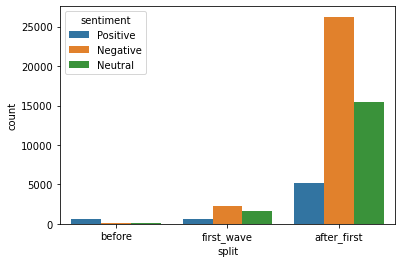

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=tweets, x="split", hue="sentiment", order=["before", "first_wave", "after_first"])

In [9]:
tweets.groupby("split")["sentiment"].value_counts(normalize=True)

split        sentiment
after_first  Negative     0.558662
             Neutral      0.330040
             Positive     0.111298
before       Positive     0.662844
             Negative     0.194954
             Neutral      0.142202
first_wave   Negative     0.509628
             Neutral      0.360949
             Positive     0.129422
Name: sentiment, dtype: float64

In [10]:
reshaped = tweets.groupby("split")["sentiment"].value_counts(normalize=True).rename("percent").reset_index()
reshaped

,split,sentiment,percent
0,after_first,Negative,0.558662
1,after_first,Neutral,0.330040
2,after_first,Positive,0.111298
3,before,Positive,0.662844
4,before,Negative,0.194954
5,before,Neutral,0.142202
6,first_wave,Negative,0.509628
7,first_wave,Neutral,0.360949
8,first_wave,Positive,0.129422


<AxesSubplot:xlabel='split', ylabel='percent'>

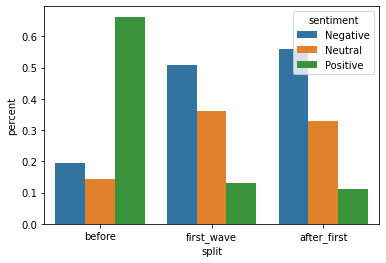

In [11]:
sns.barplot(data=reshaped, x="split", y="percent", hue="sentiment", 
            order=["before", "first_wave", "after_first"], 
            hue_order=["Negative", "Neutral", "Positive"])

<AxesSubplot:xlabel='split', ylabel='percent'>

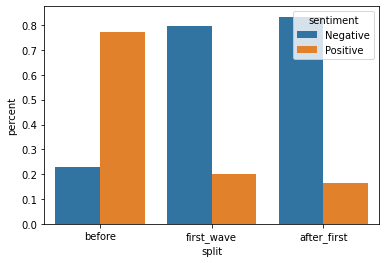

In [12]:
no_neutral = tweets[tweets["sentiment"] != "Neutral"]
reshaped_no_neutral = no_neutral.groupby("split")["sentiment"].value_counts(normalize=True).rename("percent").reset_index()
sns.barplot(data=reshaped_no_neutral, x="split", y="percent", hue="sentiment", 
            order=["before", "first_wave", "after_first"], 
            hue_order=["Negative", "Positive"])

In [13]:
grouped = tweets.set_index("created_at").sort_index().groupby("sentiment").rolling("30D").count().div(30)["text"]
grouped#.plot()

sentiment  created_at               
Negative   2019-10-10 13:20:38+00:00    0.033333
           2019-10-10 13:20:38+00:00    0.066667
           2019-10-10 13:38:36+00:00    0.100000
           2019-10-10 13:38:36+00:00    0.133333
           2019-10-10 13:50:52+00:00    0.166667
                                          ...   
Positive   2022-07-20 15:00:31+00:00    5.166667
           2022-07-20 18:07:16+00:00    5.200000
           2022-07-21 12:12:16+00:00    5.233333
           2022-07-21 13:26:47+00:00    5.266667
           2022-07-26 09:19:05+00:00    5.233333
Name: text, Length: 52302, dtype: float64

<AxesSubplot:xlabel='created_at'>

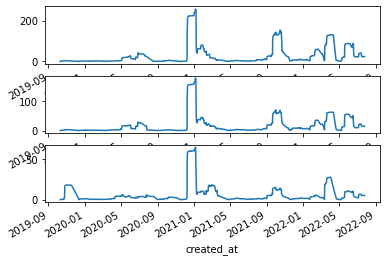

In [14]:
f, a = plt.subplots(3,1)
grouped.xs('Negative').plot(ax=a[0])
grouped.xs('Neutral').plot(ax=a[1])
grouped.xs('Positive').plot(ax=a[2])

# Findings

Switch positive to negative in the first wave.  
Not a lot of signal here between first wave and afterwards.  
Not needed, as it is shown in the network plots.  